# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
#env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")
env = UnityEnvironment(file_name="Banana.app")


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
brain



Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


prioritized_experiences_dueling_network
Episode 100	Average Score: 0.91
Episode 200	Average Score: 3.49
Episode 300	Average Score: 5.76
Episode 400	Average Score: 6.38
Episode 500	Average Score: 7.21
Episode 600	Average Score: 9.34
Episode 700	Average Score: 8.69
Episode 800	Average Score: 9.01
Episode 900	Average Score: 11.07
Episode 1000	Average Score: 9.98
Episode 1100	Average Score: 9.10
Episode 1200	Average Score: 11.21
Episode 1300	Average Score: 11.01
Episode 1400	Average Score: 10.37
Episode 1500	Average Score: 10.93
Episode 16

Environment solved in 1774 episodes!	Average Score: 15.26


prioritized_experiences_linear_network_double
Episode 100	Average Score: 0.37
Episode 200	Average Score: 3.00
Episode 300	Average Score: 6.79
Episode 400	Average Score: 7.56
Episode 500	Average Score: 10.18
Episode 599	Average Score: 13.01
Environment solved in 499 episodes!	Average Score: 13.01


Environment solved in 1873 episodes!	Average Score: 15.21


uniform_experiences_dueling_network
Episode 100	Average Score: 0.64
Episode 200	Average Score: 3.95
Episode 300	Average Score: 7.07
Episode 400	Average Score: 9.51
Episode 500	Average Score: 10.73
Episode 600	Average Score: 12.71
Episode 625	Average Score: 13.00
Environment solved in 525 episodes!	Average Score: 13.00


Episode 1149	Average Score: 15.75
Environment solved in 1049 episodes!	Average Score: 15.75


uniform_experiences_dueling_network_double
Episode 100	Average Score: 0.49
Episode 200	Average Score: 4.20
Episode 300	Average Score: 7.66
Episode 400	Average Score: 9.80
Episode 500	Average Score: 11.97
Episode 544	Average Score: 13.00
Environment solved in 444 episodes!	Average Score: 13.00


Episode 1520	Average Score: 16.05
Environment solved in 1420 episodes!	Average Score: 16.05


uniform_experiences_linear_network
Episode 100	Average Score: 0.55
Episode 200	Average Score: 3.82
Episode 300	Average Score: 7.91
Episode 400	Average Score: 9.89
Episode 500	Average Score: 12.35
Episode 524	Average Score: 13.02
Environment solved in 424 episodes!	Average Score: 13.02


Episode 877	Average Score: 16.72
Environment solved in 777 episodes!	Average Score: 16.72


uniform_experiences_linear_network_double
Episode 100	Average Score: 0.20
Episode 200	Average Score: 3.45
Episode 300	Average Score: 8.12
Episode 400	Average Score: 10.11
Episode 500	Average Score: 12.41
Episode 528	Average Score: 13.01
Environment solved in 428 episodes!	Average Score: 13.01


Episode 1073	Average Score: 16.93
Environment solved in 973 episodes!	Average Score: 16.93

uniform_experiences_linear_network_double



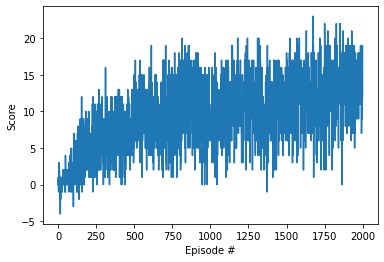


uniform_experiences_linear_network_double



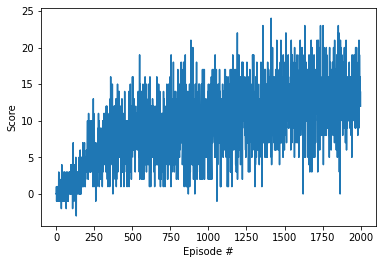


uniform_experiences_linear_network_double



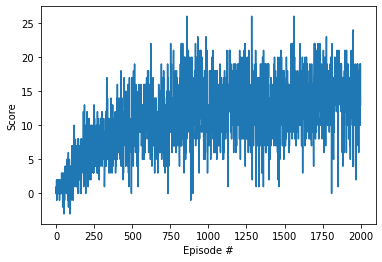


uniform_experiences_linear_network_double



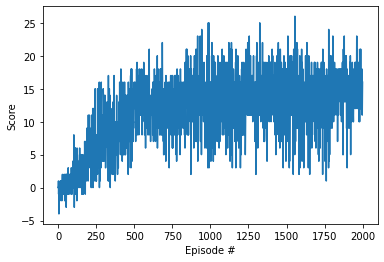


uniform_experiences_linear_network_double



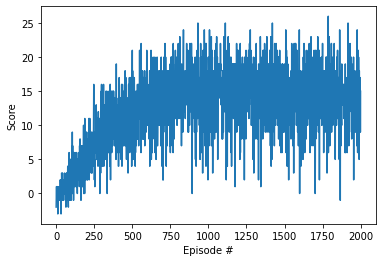


uniform_experiences_linear_network_double



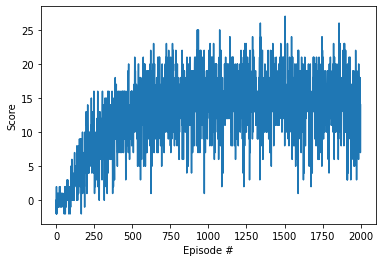


uniform_experiences_linear_network_double



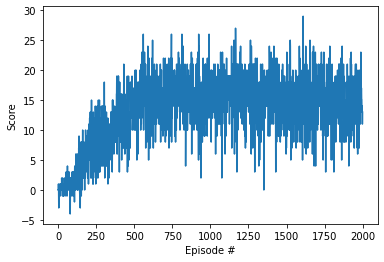


uniform_experiences_linear_network_double



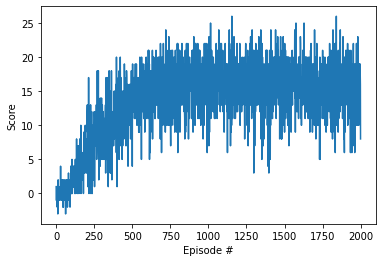

In [4]:
import torch
from lib.agents import AgentExperienceReplay, AgentPrioritizedExperienceReplay
from lib.models import QNetwork, DuelingQNetwork

from lib.dqn import dqn

import matplotlib.pyplot as plt
%matplotlib inline
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

def create_dueling_model(state_size, action_size, seed):
    return DuelingQNetwork(state_size, action_size, seed)

def create_linear_model(state_size, action_size, seed):
    return QNetwork(state_size, action_size, seed)

n_episodes=2000
scores = []
agent_info = []
# 1
agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                   create_model=create_dueling_model,
                                   double_dqn=False
                                  )
agent_info.append({'agent': agent, 'name': 'prioritized_experiences_dueling_network', 'test': True})

# 2
agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                   create_model=create_dueling_model,
                                   double_dqn=True
                                  )
agent_info.append({'agent': agent, 'name': 'prioritized_experiences_dueling_network_double', 'test': True})

# 3
agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                   create_model=create_linear_model,
                                   double_dqn=False
                                  )
agent_info.append({'agent': agent, 'name': 'prioritized_experiences_linear_network', 'test': True})

# 4
agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                   create_model=create_linear_model,
                                   double_dqn=True
                                  )
agent_info.append({'agent': agent, 'name': 'prioritized_experiences_linear_network_double', 'test': True})

# 5
agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                   create_model=create_dueling_model,
                                   double_dqn=False
                                  )
agent_info.append({'agent': agent, 'name': 'uniform_experiences_dueling_network', 'test': True})

# 6
agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                   create_model=create_dueling_model,
                                   double_dqn=True
                                  )
agent_info.append({'agent': agent, 'name': 'uniform_experiences_dueling_network_double', 'test': True})

# 7

agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                create_model=create_linear_model,
                                double_dqn=False
                                  )
agent_info.append({'agent': agent, 'name': 'uniform_experiences_linear_network', 'test': True})

# 8

agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                create_model=create_linear_model,
                                double_dqn=True
                                  )
agent_info.append({'agent': agent, 'name': 'uniform_experiences_linear_network_double', 'test': True})


for info in agent_info:
    if info["test"]:
        agent_name = info['name']
        print(f"\n\n{agent_name}")
        env_info = env.reset(train_mode=True)[brain_name]
        agent = info['agent']
        scores.append(dqn(env, 
                          brain_name, 
                          agent, 
                          n_episodes=n_episodes, 
                          checkpoint=13,
                          agent_name=agent_name))
        agent.save_model(agent_name)


# plot the scores
for instance_scores in scores:
    print(f"\n{info['name']}\n")
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(instance_scores)), instance_scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

